In [1]:
import numpy as np
from numpy.random import default_rng
import pandas as pd
import scipy.optimize as opt
import matplotlib.pyplot as plt
import seaborn as sns
from typing import NamedTuple, Dict
from sklearn import linear_model

import warnings
warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)

In [2]:
def calc_Y(A_in: np.ndarray, e_in: np.ndarray, u_in: np.ndarray, alpha: float, beta: float, pi:float) -> np.ndarray:
    """
    Y = np.exp(alpha + beta*A + e) + pi*A + u
    """
    A = np.copy(A_in)
    e = np.copy(e_in)
    u = np.copy(u_in)
    return np.exp(alpha + beta*A + e) + pi*A + u

def calc_A(Z_in: np.ndarray, e_in: np.ndarray, gamma: np.ndarray, delta: float) -> np.ndarray:
    """
    A = gamma*Z + delta*e
    """
    Z = np.copy(Z_in)
    e = np.copy(e_in)
    return np.dot(gamma, Z.T) + delta*e
        

def generatate_data(n_sample: int, params: np.ndarray,  seed=1001, Zdim: int = 1, 
                    Z_noise: float = np.sqrt(3), u_noise: float = 1, e_noise: float = 1):
    rng = default_rng(seed=seed)
    alpha, beta, gamma, delta, pi = params
    
    u = rng.normal(0, u_noise, n_sample)
    e = rng.normal(0, e_noise, n_sample)
    Z = rng.normal(0, Z_noise, [n_sample, Zdim])
    A = calc_A(Z, e, gamma, delta) 
    Y = calc_Y(A, e, u, alpha, beta, pi)
    return u, e, Z, A, Y

def cal_true_effect(a: float, params, u_noise: float = 1, e_noise: float = 1, n_MC: int = 10000):
    """
    To estimate true effect
    n_MC affects MC error, seed is fixed!
    """
    rng = default_rng(seed=42)
    alpha, beta, gamma, delta, pi = params
    
    u = rng.normal(0, u_noise, n_MC)
    e = rng.normal(0, e_noise, n_MC)
    Y = calc_Y(a, e, u, alpha, beta, pi) 
    return np.mean(Y)


def generate_struc_data(params, a_start: float, a_end: float, n_steps: int = 100, 
                        u_noise: float = 1, e_noise: float = 1, n_MC: int = 10000):
    """
    from a_start to a_end, calc Y effect
    """
    a_steps = np.linspace(a_start, a_end, n_steps)
    y_struc = np.array([cal_true_effect(a, params, u_noise, e_noise, n_MC) for a in a_steps])
    return a_steps, y_struc

### Need a LOT of Samples!

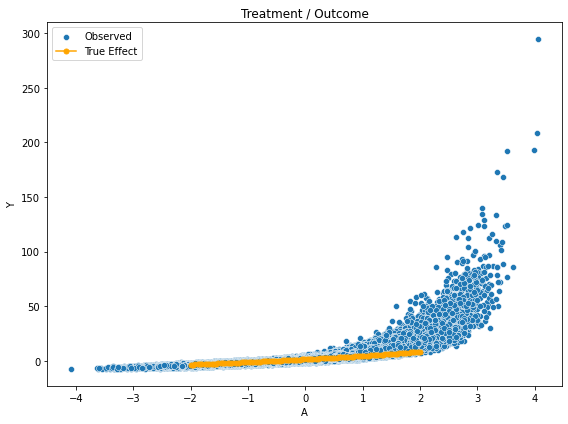

In [3]:
# Sample Parameters
random_seed = 1001
n_sample = 500000
n_MC = 10000
# Number of Instruments
Zdim = 3
# True Parameters
alpha_true = 0.01
beta_true = 0.6
gamma_true = np.array([0.1, 0.2, 0.15])
delta_true = 1 
pi_true = 2
params_true = np.array([alpha_true, beta_true, gamma_true, delta_true, pi_true])
# Noise Parameters
u_noise = np.sqrt(0.5)
e_noise = np.sqrt(0.5)
Z_noise = np.sqrt(3)

u_data, e_data, Z_data, A_data, Y_data = generatate_data(n_sample, params_true,  seed=random_seed, Zdim = Zdim, 
                                                         Z_noise = Z_noise, u_noise = u_noise, e_noise = e_noise)

# generate structural Data (True Effect)
a_steps, y_struc = generate_struc_data(params_true, a_start=-2, a_end=2, n_steps = 100, 
                                       u_noise = u_noise, e_noise=e_noise, n_MC = n_MC)

# Plot Results
fig, (ax1) = plt.subplots(1, 1, figsize=(8, 6))

sns.scatterplot(x=A_data, y=Y_data, label='Observed', ax=ax1)
ax1.plot(a_steps, y_struc, color='orange', marker='o', label="True Effect", markersize=5)
ax1.set_title('Treatment / Outcome')
ax1.set_xlabel('A')
ax1.set_ylabel('Y')
ax1.legend()


# fig.suptitle('Visualization')
plt.tight_layout()
plt.show()

## GMM

In [4]:
def calc_error(Y_in:np.ndarray, A_in: np.ndarray, alpha: float, beta: float, pi: float, e_noise:float) -> np.ndarray:
    """
    error
    """
    A = np.copy(A_in)
    Y = np.copy(Y_in)
    return (Y - pi*A) * np.exp(-alpha-beta*A)*np.exp(-e_noise**2 / 2) - 1

def g_vec(Y_in, A_in, Z_in, e_noise, params_in):
    # Var
    A = np.copy(A_in)
    Y = np.copy(Y_in)
    Z = np.copy(Z_in)
    # calc error (problem specific)
    alpha_in, beta_in, pi_in = params_in
    alpha = np.copy(alpha_in)
    beta = np.copy(beta_in)
    pi = np.copy(pi_in)
    
    # new
    err = calc_error(Y, A, alpha, beta, pi, e_noise).reshape(-1, 1)
    g = np.mean(Z * err, axis = 0).reshape(-1, 1)
    ####
    
    # old
#     err = calc_error(Y, A, alpha, beta, pi, e_noise)
#     m1 = np.mean(Z[:, 0] * err)
#     m2 = np.mean(Z[:, 1] * err)
#     m3 = np.mean(Z[:, 2] * err)
#     g =  np.column_stack((m1, m2, m3)).T
    ####
    return g

def criterion(params, *var): 
    """
    c(params) = g.T(params) W_hat g(params)
    Aim: min c in params
    """
    Y, var_model, var_inst, W_hat, e_noise = var
    g = g_vec(Y, var_model, var_inst, e_noise, params)
    crit_val = np.dot(np.dot(g.T, W_hat), g) 
    return crit_val

In [5]:
# True Parameters
params_true = np.array([alpha_true, beta_true, pi_true])
print("True", params_true)
# Initial Parameters
alpha_init = 0
beta_init = 0
pi_init = 1
params_init = np.array([alpha_init, beta_init, pi_init])

W_hat = np.eye(3)


var_model = A_data
var_inst = Z_data
gmm_args = (Y_data, A_data, Z_data, W_hat, e_noise)
print("Initial Result:", criterion(params_init, *gmm_args))

results = opt.minimize(criterion, params_init, args=(gmm_args), tol=1e-8, options  = {"maxiter":100000, "disp":True})
results

True [0.01 0.6  2.  ]
Initial Result: [[1.88203444]]
Optimization terminated successfully.
         Current function value: 0.000003
         Iterations: 161
         Function evaluations: 784
         Gradient evaluations: 196


      fun: 2.9174357161602025e-06
 hess_inv: array([[172814.58506526,  25143.56041298, -13399.44362783],
       [ 25143.56040728,  65009.30548748, -34299.89548246],
       [-13399.44362483, -34299.89548249,  18097.67533032]])
      jac: array([-3.37649908e-11,  2.31267450e-10,  4.96811481e-10])
  message: 'Optimization terminated successfully.'
     nfev: 784
      nit: 161
     njev: 196
   status: 0
  success: True
        x: array([0.01321478, 0.74476126, 1.89818063])

In [6]:
def cal_pred_effect(a: float, params_pred):
    """
    To estimate pred effect
    """
    
    alpha, beta, pi = params_pred
    y = np.exp(alpha + beta*a)*np.exp(e_noise**2 / 2) + pi*a 
    return y

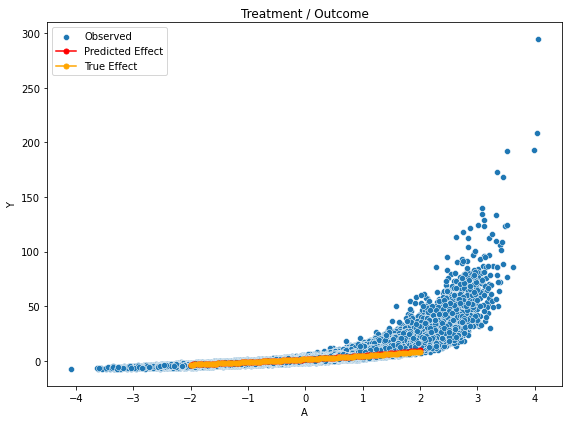

In [7]:
params_pred = results.x
#params_pred = [alpha_true, beta_true, pi_true]
y_pred = [cal_pred_effect(a, params_pred) for a in a_steps]

fig, (ax1) = plt.subplots(1, 1, figsize=(8, 6))

sns.scatterplot(x=A_data, y=Y_data, label='Observed', ax=ax1)
ax1.plot(a_steps, y_pred, color='red', marker='o', label="Predicted Effect", markersize=5)
ax1.plot(a_steps, y_struc, color='orange', marker='o', label="True Effect", markersize=5)


ax1.set_title('Treatment / Outcome')
ax1.set_xlabel('A')
ax1.set_ylabel('Y')
ax1.legend()


# fig.suptitle('Visualization')
plt.tight_layout()
plt.show()